In [1]:
# Fangjun Hu

import numpy as np
import matplotlib.pyplot as plt

import random
from numpy.random import randn as randn
from copy import deepcopy
import time

import torchvision.datasets as datasets
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

from scipy.optimize import curve_fit

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. MNIST and Gaussian Noise Data

(60000, 28, 28)


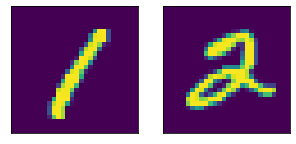

In [19]:
# Load full MNIST data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

train_data = mnist_trainset.data.numpy()

rseed = 12345 # seed for generator
random.seed(rseed)

N_tr = 60000
train_data_full   = np.zeros((N_tr, 28, 28))
train_index = np.sort(random.sample(range(60000), k=N_tr))
for i in range(N_tr):
    c = train_index[i]
    train_data_full[i,:,:] = train_data[c,:,:]

sum_first_row = train_data_full[:, 0, :].sum()
sum_first_col = train_data_full[:, :, 0].sum()
total_sum = sum_first_row + sum_first_col
total_sum, sum_first_row

### Scaling by 1/255
# train_data_full = train_data_full[:, 1:, 1:]
train_data_full = train_data_full/255

print(train_data_full.shape)
    
nCl = 10
Ls  = 28   # Linear size
nr, nc = 28, 28
dim = nr * nc

fig, axs = plt.subplots(1, 2, figsize=(5,5))
ax = axs[0]
ax.imshow(train_data_full[3], vmin=0, vmax=1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = axs[1]
ax.imshow(train_data_full[5], vmin=0, vmax=1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [20]:
## Generate Gaussian Noise

mean = 0.0
std  = 1.0
seed = 12345

np.random.seed(seed)
noise_full = np.random.normal(loc=mean, scale=std, size=(N_tr, nr, nc))
noise_full.shape

(60000, 28, 28)

# 2. MINE Function

In [23]:
def images_to_X_ABC(images):

    # Define center and neighborhood
    ic, jc = Ls//2, Ls//2
    max_r = (Ls - 1) // 2 - 1
    
    X_A = []
    X_B_dict = {r: [] for r in range(1, max_r + 1)}
    X_BC = []
    
    for img in images:
        
        if ic - max_r < 0 or ic + max_r >= Ls or jc - max_r < 0 or jc + max_r >= Ls:
            continue
        
        img_A = img[ic:ic+1, jc:jc+1]
        X_A.append(img_A)
        
        img_BC = deepcopy(img)                                                          # Remove A from ABC
        img_BC[ic:ic+1, jc:jc+1] = 0
        X_BC.append(img_BC)

        for r in range(1, max_r + 1):

            img_B = np.zeros((Ls, Ls))
            img_B[ic-r:ic+r+1, jc-r:jc+r+1] = img[ic-r:ic+r+1, jc-r:jc+r+1]         # Region AB 
            img_B[ic:ic+1, jc:jc+1] = np.zeros((1, 1))                              # Remove A from AB
    
            X_B_dict[r].append(img_B)
    
    X_A  = np.array(X_A)
    X_A  = torch.tensor(X_A, dtype=torch.float32).unsqueeze(1)
    X_BC = np.array(X_BC)
    X_BC = torch.tensor(X_BC, dtype=torch.float32).unsqueeze(1)
    
    return X_A, X_B_dict, X_BC

In [24]:
def learn_mine(XZ_joint, XZ_marg, mine_net, mine_net_optim, ma_et, ma_rate=0.001, unbias=True):
    
    # batch_2D is a tuple of (XZ_joint, XZ_marg)
    
    XZ_joint = torch.autograd.Variable(torch.FloatTensor(XZ_joint)).to(device)
    XZ_marg  = torch.autograd.Variable(torch.FloatTensor(XZ_marg)).to(device)
    
    # Compute T(x, z) and T(x, z~)
    T_joint = mine_net(XZ_joint)  # shape: [batch_size, ..]
    T_marg  = mine_net(XZ_marg)   # shape: [batch_size, ..]

    # Lower bound V(theta)
    T_joint_mean = T_joint.mean()
    T_marg_exp = torch.exp(T_marg)
    T_marg_mean_exp = T_marg_exp.mean()
    
    # Estimated Mutual Info \hat{I}_DV(X, Z)
    mi_est = T_joint_mean - torch.log(T_marg_mean_exp)
    
    # Moving average for stability
    if ma_et is None:
        ma_et = T_marg_mean_exp.detach()
    else:
        ma_et = (1 - ma_rate) * ma_et + ma_rate * T_marg_mean_exp
    
    # Optimization Loss with Moving Average L(x, z)
    if unbias == True:
        loss = - ( T_joint_mean - (1/ma_et).detach() * T_marg_mean_exp )
    else:
        loss = - mi_est
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    
    return mi_est, ma_et
    # return mi_est, ma_et, T_joint_mean, torch.log(T_marg_mean_exp)

In [25]:
def test_mine(XZ_joint, XZ_marg, mine_net):
    
    # batch_2D is a tuple of (XZ_joint, XZ_marg)
    
    XZ_joint = torch.autograd.Variable(torch.FloatTensor(XZ_joint)).to(device)
    XZ_marg  = torch.autograd.Variable(torch.FloatTensor(XZ_marg)).to(device)
    
    # Compute T(x, z) and T(x, z~)
    T_joint = mine_net(XZ_joint)  # shape: [batch_size, ..]
    T_marg  = mine_net(XZ_marg)   # shape: [batch_size, ..]

    # Lower bound V(theta)
    T_joint_mean = T_joint.mean()
    T_marg_exp = torch.exp(T_marg)
    T_marg_mean_exp = T_marg_exp.mean()
    
    # Estimated Mutual Info \hat{I}_DV(X, Z)
    mi_est = T_joint_mean - torch.log(T_marg_mean_exp)

    return mi_est

In [26]:
def sample_batch(X_samples, Z_samples, batch_size=500, reshuffle=True, resample_surroundings=True):
    
    ### X is center, Z is Surroundings

    sample_size = X_samples.shape[0]

    # Sample minibatch from joint 
    idx = torch.randint(0, sample_size, (batch_size,))
    X_batch_joint  = X_samples[idx]
    Z_batch_joint  = Z_samples[idx]

    if reshuffle == False:
        idx_marg = torch.randint(0, sample_size, (batch_size,))   # Sample marginal X and Z independently
        X_batch_marg  = X_samples[idx_marg]
        Z_batch_marg  = Z_samples[idx_marg]
    else:
        idx_marg = torch.randperm(batch_size)              # Sample marginal X and Z by reshuffling
        X_batch_marg = X_batch_joint[idx_marg]
        Z_batch_marg = Z_batch_joint[idx_marg]

    l = Ls//2
    if resample_surroundings == True:
        XZ_joint = deepcopy(Z_batch_joint)                 
        XZ_joint[:, :, l:l+1, l:l+1] = X_batch_joint
        XZ_marg = deepcopy(Z_batch_marg)                
        XZ_marg[: , :, l:l+1, l:l+1] = X_batch_joint   # Keep the center unchanged
    else:
        XZ_joint = deepcopy(Z_batch_joint)              
        XZ_joint[:, :, l:l+1, l:l+1] = X_batch_joint
        XZ_marg = deepcopy(Z_batch_joint)                  # Keep the surroundings unchanged
        XZ_marg[: , :, l:l+1, l:l+1] = X_batch_marg

    return XZ_joint, XZ_marg

In [27]:
def train_NN(X_samples, Z_samples, mine_net, mine_net_optim, scheduler, batch_size=500, iter_num=12000):

    epoch_num = int(N_tr/batch_size)
    
    result     = []
    ma_et      = 1
    
    for i in range(iter_num):
        
        XZ_joint, XZ_marg = sample_batch(X_samples, Z_samples, batch_size=batch_size)
        mi_est, ma_et = learn_mine(XZ_joint, XZ_marg, mine_net, mine_net_optim,
                                   ma_et, unbias=True)
        
        result.append(mi_est.detach().cpu().numpy())

        if (i+1)%epoch_num == 0:
            scheduler.step()
        
    result = np.array(result)
    return result

def ma(a, window_size=100):
    return [np.mean(a[i:i + window_size]) for i in range(0, len(a) - window_size)]

In [28]:
input_size  = 28
kernel_size = 3
n_padding   = 0
L_conv = int(np.floor((input_size - kernel_size + 2*n_padding)/1) + 1)
L_pool = int(np.floor((L_conv - 2)/2) + 1)
print(f'Size after Pool: {L_pool}')

class MineCNN(nn.Module):
    def __init__(self, input_size=28, kernel_size=3, hidden_size=256, out_channels=32, n_padding=0, dropout_conv=0.10, dropout_fc=0.30):
        super(MineCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=n_padding)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(p=dropout_conv)
        
        ## flatten → FC
        L_conv = int(np.floor((input_size - kernel_size + 2*n_padding)/1) + 1)
        L_pool = int(np.floor((L_conv - 2)/2) + 1)
        self.fc1 = nn.Linear(out_channels * L_pool * L_pool, hidden_size)
        self.dropout_fc = nn.Dropout(p=dropout_fc)

        # Output T_theta(x, z)
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, 1, L, L)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        return self.fc_out(x)  # Output shape: (B, 1)

Size after Pool: 13


# 3. Example of CMI, given $\alpha$ and $r$

Time: 3.23848295211792s.


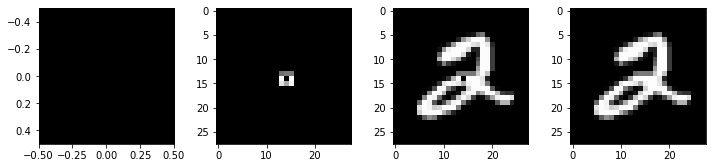

In [33]:
start_time = time.time()

alpha = 0.0
images = (1 - alpha) * train_data_full + (alpha) * noise_full
X_A, X_B_dict, X_BC = images_to_X_ABC(images)

print(f'Time: {time.time() - start_time}s.')

r = 1
X_B = np.array(X_B_dict[r])
X_B = torch.tensor(X_B, dtype=torch.float32).unsqueeze(1)

idx = 5
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes[0].imshow(X_A[idx, 0],  cmap='gray')
axes[1].imshow(X_B[idx, 0],  cmap='gray')
axes[2].imshow(X_BC[idx,0],  cmap='gray')
axes[3].imshow(images[idx],  cmap='gray')
plt.tight_layout()
plt.show()

In [37]:
batch_size   = 100
num_epoch    = 500
num_steps    = int(N_tr/batch_size) * num_epoch
window_size  = int(num_steps/10)
lr           = 1e-4
weight_decay = 1e-4
step_size    = 1000
gamma        = 1

num_steps, int(N_tr/batch_size) * num_epoch

(300000, 300000)

In [38]:
start_time = time.time()

for i in range(1):  ## Integer i indicates the repetition number, usually just 1 or 3
    
    mine_net_ABC = MineCNN(input_size=Ls).to(device)
    
    mine_net_optim_ABC = optim.AdamW(mine_net_ABC.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler_ABC      = optim.lr_scheduler.StepLR(mine_net_optim_ABC, step_size=step_size, gamma=gamma)
    
    result_ABC = train_NN(X_A, X_BC, mine_net_ABC, mine_net_optim_ABC, scheduler_ABC,
                          batch_size=batch_size, iter_num=num_steps)

    print(f'I(A:BC) = {np.mean(result_ABC[-window_size:])}. Time: {time.time() - start_time}s.')


I(A:BC) = 1.0656816959381104. Time: 803.6455078125s.


In [39]:
start_time = time.time()

for i in range(1):
    
    mine_net_AB = MineCNN(input_size=Ls).to(device)
    
    mine_net_optim_AB = optim.AdamW(mine_net_AB.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler_AB      = optim.lr_scheduler.StepLR(mine_net_optim_AB, step_size=step_size, gamma=gamma)
    
    result_AB = train_NN(X_A, X_B, mine_net_AB, mine_net_optim_AB, scheduler_AB,
                          batch_size=batch_size, iter_num=num_steps)

    print(f'I(A:B) = {np.mean(result_AB[-window_size:])}. Time: {time.time() - start_time}s.')
    

I(A:B) = 1.0500073432922363. Time: 807.3224849700928s.


# 4. CMI along Diffusion

In [42]:
n_t   = 10
max_r = (Ls - 1) // 2 - 1

tn_list    = np.array(range(0, n_t + 1))
alpha_list = tn_list/n_t
r_list     = np.array(range(1, max_r + 1))

print(tn_list)
print(np.array(r_list))
print(alpha_list)

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [43]:
batch_size   = 100
num_epoch    = 500
num_steps    = int(N_tr/batch_size) * num_epoch
window_size  = int(num_steps/10)
lr           = 1e-4
weight_decay = 1e-4
step_size    = 1000
gamma        = 1

print(num_steps)

300000


In [44]:
start_time = time.time()

RPT = 3      # Repeat multiple times and take the mean to make the estimation of the upper bound I_{DV} more robust
mi_ABC_array = np.zeros((n_t + 1, RPT))

for tn in tn_list:
# for tn in [7]:

    alpha = alpha_list[tn]

    ## Generate Noise Images along Diffusion Path
    images = (1 - alpha) * train_data_full + (alpha) * noise_full
    X_A, X_B_dict, X_BC = images_to_X_ABC(images)

    for rpt in range(RPT):
    
        ## Compute I(A:BC)
        mine_net_ABC = MineCNN(input_size=Ls).to(device)
        mine_net_optim_ABC = optim.AdamW(mine_net_ABC.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler_ABC      = optim.lr_scheduler.StepLR(mine_net_optim_ABC, step_size=step_size, gamma=gamma)
    
        result_ABC = train_NN(X_A, X_BC, mine_net_ABC, mine_net_optim_ABC, scheduler_ABC,
                              batch_size=batch_size, iter_num=num_steps)
        
        mi_ABC = np.mean(result_ABC[-window_size:])
        mi_ABC_array[tn, rpt] = mi_ABC
    
        # print(f'alpha = {tn}/{n_t}, I(A:BC) = {mi_ABC}. Time = {np.round(time.time() - start_time, 1)}s (Round {rpt+1}).')

mi_ABC_list = np.mean(mi_ABC_array, axis=1)

# ### Take the maximum of I(A:BC) at different t
# filename = f'./results_cmi/mi_ABC_array.npy'
# np.save(filename, mi_ABC_array)

In [46]:
filename = f'./results_cmi/mi_ABC_array.npy'
mi_ABC_array_store = np.load(filename)
mi_ABC_list_store  = np.max(mi_ABC_array_store, axis=1)

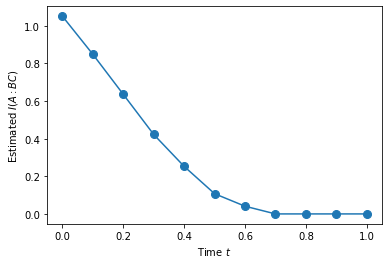

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes
ax.plot(alpha_list, mi_ABC_list_store, marker='o', markersize=8)
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'Estimated $I(A:BC)$')
plt.show()

In [45]:
start_time = time.time()

for tn in tn_list:
# for tn in [0]:

    alpha  = alpha_list[tn]
    mi_ABC = mi_ABC_list_store[tn]
    
    ## Generate Noise Images along Diffusion Path
    images = (1 - alpha) * train_data_full + (alpha) * noise_full
    X_A, X_B_dict, X_BC = images_to_X_ABC(images)

    ## Scan I(A:B) with different r
    mi_AB_r = np.zeros(max_r)
    cmi_r   = np.zeros(max_r)

    for r in r_list:
    # for r in [1]:
    
        X_B = np.array(X_B_dict[r])
        X_B = torch.tensor(X_B, dtype=torch.float32).unsqueeze(1)
        
        mine_net_AB       = MineCNN(input_size=Ls).to(device)
        mine_net_optim_AB = optim.AdamW(mine_net_AB.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler_AB      = optim.lr_scheduler.StepLR(mine_net_optim_AB, step_size=step_size, gamma=gamma)

        result_AB = train_NN(X_A, X_B, mine_net_AB, mine_net_optim_AB, scheduler_AB,
                             batch_size=batch_size, iter_num=num_steps)
        
        mi_AB = np.mean(result_AB[-window_size:])
        cmi   = mi_ABC - mi_AB
    
        mi_AB_r[r-1] = mi_AB
        cmi_r[r-1]   = cmi

        # print(f'alpha = {tn}/{n_t}, r = {r}, CMI = {cmi}, I(A:B) = {mi_AB}. Time={np.round(time.time() - start_time, 1)}s.')

    # ### Store I(A:B) of r, at time t
    # filename = f'./results_cmi_padding_k1/Padding_mi_AB_{tn}_in_{n_t}.npy'
    # np.save(filename, mi_AB_r)
    

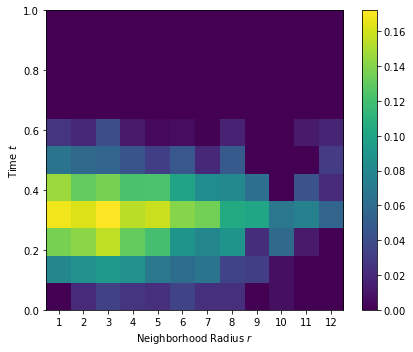

In [48]:
cmi_array = np.zeros((n_t + 1, max_r))

filename = f'./results_cmi/mi_ABC_array.npy'
mi_ABC_array_store = np.load(filename)
mi_ABC_list_store  = np.max(mi_ABC_array_store, axis=1)

for r in r_list:
    for tn in tn_list:
        filename = f'./results_cmi/mi_AB_{tn}_in_{n_t}.npy'
        mi_AB_r_store = np.load(filename)
        cmi_array[tn, r-1] = mi_ABC_list_store[tn] - mi_AB_r_store[r-1]

cmi_array = np.clip(cmi_array, a_min=0, a_max=None)

plt.figure(figsize=(6, 5))
im = plt.imshow(cmi_array, aspect='auto', origin='lower', 
                extent=[min(r_list)-0.5, max(r_list)+0.5, 0, 1],
                cmap='viridis')

plt.colorbar(im)
plt.xlabel(r'Neighborhood Radius $r$')
plt.ylabel(r'Time $t$')
plt.xticks(r_list)
plt.tight_layout()
plt.show()